## 0. Architecture of a classification neural network
Hyperparameter
- `Input layer shape` (in_features)
- `Hidden Layers`
- `Neurons per hidden layer`
- `Output layer shape` (out_features)
- `Hidden layers activation` usually ReLU
- `Output activation function` torch.sigmoid (Binary classification) || torch.softmax (Multiclass classification)
- `Loss function` torch.nn.BCELoss || torch.nn.CrossEntropyLoss
- `Optimizer` torch.nn.optim

## 1. Make classification data and get it ready

In [244]:
from sklearn.datasets import make_circles


# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

In [245]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [246]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                       "X2": X[:, 1],
                       "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [247]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

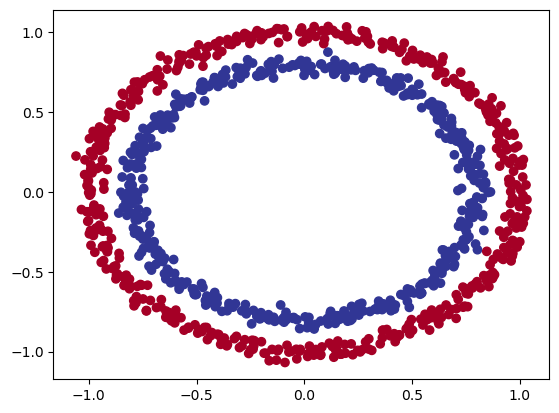

In [248]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y,
            cmap=plt.cm.RdYlBu)

### 1.1 Input and output shapes

In [249]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [250]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()



This tells us the second dimension for X means it has two features (vector) where as y has a single feature (scalar).

### 1.2 Turn data into tensors and create train and test splits


In [251]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [252]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state= 42)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

### 2.Building a model

We'll break it down into a few parts.

Setting up device agnostic code (so our model can run on CPU or GPU if it's available).

Constructing a model by subclassing nn.Module.

Defining a loss function and optimizer.

Creating a training loop (this'll be in the next section).

In [253]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [254]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
    
    def forward(self, x):
        return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [255]:
# Replicate Circle Model with nn.Sequential()

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

Woah, that looks much simpler than subclassing nn.Module, why not just always use nn.Sequential?

nn.Sequential is fantastic for straight-forward computations, however, as the namespace says, it always runs in sequential order.

In [256]:
#Make prediction with model
untrained_prediction = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_prediction)}, Shape: {untrained_prediction.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"First of 10 predictions: {untrained_prediction[:10]}")
print(f"First of 10 test sample: {y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])
First of 10 predictions: tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]], grad_fn=<SliceBackward0>)
First of 10 test sample: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1. Setup loss and optimizer

In [257]:
# Create a loss function
# loss_fn = nn.BCELoss() # no sigmoid built-in 
loss_fn = nn.BCEWithLogitsLoss()

#Create a optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)


In [258]:
# Caculate accuracy 
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## 3.Train model

### 3.1 Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels)

In [259]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], grad_fn=<SliceBackward0>)

![Alt text](<Screenshot 2024-02-04 at 11.12.43.png>)

In [260]:
y_preds_probs = torch.sigmoid(y_logits)
y_preds_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], grad_fn=<SigmoidBackward0>)

In [261]:
y_preds = torch.round(y_preds_probs)

#In full
y_preds_label = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

#Check for equality
print(torch.eq(y_preds.squeeze(), y_preds_label.squeeze()))

tensor([True, True, True, True, True])


To recap, we converted our model's raw outputs (logits) to predicition probabilities using a sigmoid activation function.

And then converted the prediction probabilities to prediction labels by rounding them.



### 3.1. Building a training and testing loop

In [262]:
torch.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

    ### Training
    model_0.train()

    y_logits = model_0(X_train).squeeze() # squeeze to remove extra 1 dimension
    y_preds = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train) #using nn.BCEWithLogisLoss work with raw logits
    acc = accuracy_fn(y_true= y_train, y_pred=y_preds)
    #Zero gardient
    optimizer.zero_grad()
    #Backpropagation
    loss.backward()
    #Update paramaters
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        #Forward pass
        y_logits_test = model_0(X_test).squeeze()
        y_preds_test = torch.round(torch.sigmoid(y_logits_test))
        #Caculate loss/ accuracy
        test_loss = loss_fn(y_logits_test, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=y_preds_test)

        if epoch % 10 == 0:
            print(f"Epochs {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f} | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f} ")

Epochs 0 | Loss: 0.69796, Accuracy: 51.88 | Test Loss: 0.69440, Test Accuracy: 58.00 
Epochs 10 | Loss: 0.69590, Accuracy: 51.25 | Test Loss: 0.69305, Test Accuracy: 53.00 
Epochs 20 | Loss: 0.69490, Accuracy: 51.62 | Test Loss: 0.69254, Test Accuracy: 49.50 
Epochs 30 | Loss: 0.69435, Accuracy: 51.12 | Test Loss: 0.69236, Test Accuracy: 49.50 
Epochs 40 | Loss: 0.69401, Accuracy: 50.88 | Test Loss: 0.69232, Test Accuracy: 51.00 
Epochs 50 | Loss: 0.69378, Accuracy: 50.25 | Test Loss: 0.69234, Test Accuracy: 50.00 
Epochs 60 | Loss: 0.69362, Accuracy: 50.00 | Test Loss: 0.69239, Test Accuracy: 51.50 
Epochs 70 | Loss: 0.69351, Accuracy: 50.25 | Test Loss: 0.69246, Test Accuracy: 51.00 
Epochs 80 | Loss: 0.69342, Accuracy: 49.88 | Test Loss: 0.69254, Test Accuracy: 50.00 
Epochs 90 | Loss: 0.69336, Accuracy: 49.88 | Test Loss: 0.69262, Test Accuracy: 53.00 


The accuracy barely moves above 50% on each data split.

And because we're working with a balanced binary classification problem, it means our model is performing as good as random guessing (with 500 samples of class 0 and class 1 a model predicting class 1 every single time would achieve 50% accuracy).

## 4. Make prediction and evalate the model

In [263]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


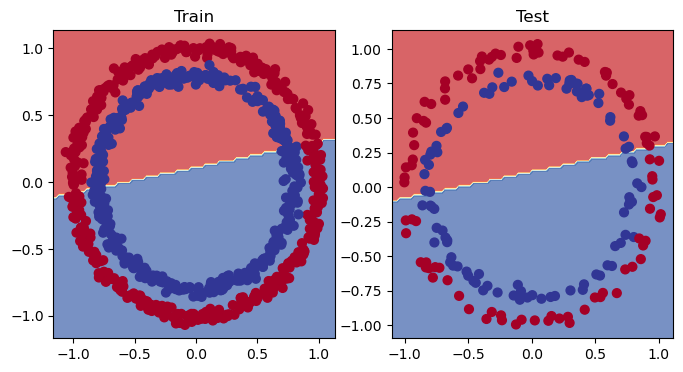

In [264]:
#Plot decision boundaries for train, test
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)


`In machine learning terms, our model is underfitting, meaning it's not learning predictive patterns from the data.`

## 5. Improving a model (from a model perpective)

`Add more layers`

`Add more hidden units`

`Fitting for longer`

`Changing the activation function`

`Changing the learning rate`

`Changing the loss function`

`Use transfer learning`

Let's see what happens if we add an extra layer to our model, fit for longer (epochs=1000 instead of epochs=100) and increase the number of hidden units from 5 to 10.



In [265]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,out_features=10)
        self.layer_2 = nn.Linear(in_features=10,out_features=10)
        self.layer_3 = nn.Linear(in_features=10,out_features=1)
    
    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [266]:
loss_fn = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [267]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

#Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train()

    # Put forward
    y_logits = model_1(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    # Caculate to loss/accuracy
    loss = loss_fn(y_logits,y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

    # Zero gradient
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # Update parameters
    optimizer.step()

    ### Testing
    model_1.eval()
    
    with torch.inference_mode():
        y_logits_test = model_1(X_test).squeeze()
        y_preds_test = torch.round(torch.sigmoid(y_logits_test))

        #Caculate test loss/accuracy
        test_loss = loss_fn(y_logits_test, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=y_preds_test)

        if epoch % 100 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f} | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}")

Epoch: 0 | Loss: 0.69396, Accuracy: 50.88 | Test Loss: 0.69261, Test Accuracy: 51.00
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38 | Test Loss: 0.69379, Test Accuracy: 48.00
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12 | Test Loss: 0.69437, Test Accuracy: 46.00
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62 | Test Loss: 0.69458, Test Accuracy: 45.00
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12 | Test Loss: 0.69465, Test Accuracy: 46.00
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00 | Test Loss: 0.69467, Test Accuracy: 46.00
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00 | Test Loss: 0.69468, Test Accuracy: 46.00
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00 | Test Loss: 0.69468, Test Accuracy: 46.00
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00 | Test Loss: 0.69468, Test Accuracy: 46.00
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00 | Test Loss: 0.69468, Test Accuracy: 46.00


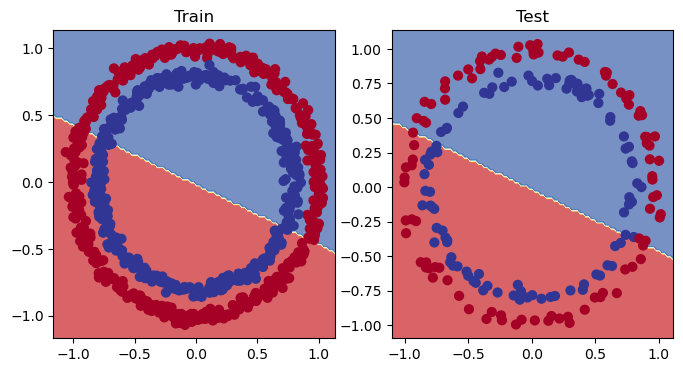

In [268]:
# Plot decision boundary for train, test set
plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can model a straight line

In [269]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = X_regression * weight + bias

print(len(X_regression))
print(f"{X_regression[:5]},\n {y_regression[:5]}")

100
tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400]]),
 tensor([[0.3000],
        [0.3070],
        [0.3140],
        [0.3210],
        [0.3280]])


In [270]:
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

len(X_train_regression), len(X_test_regression)

(80, 20)

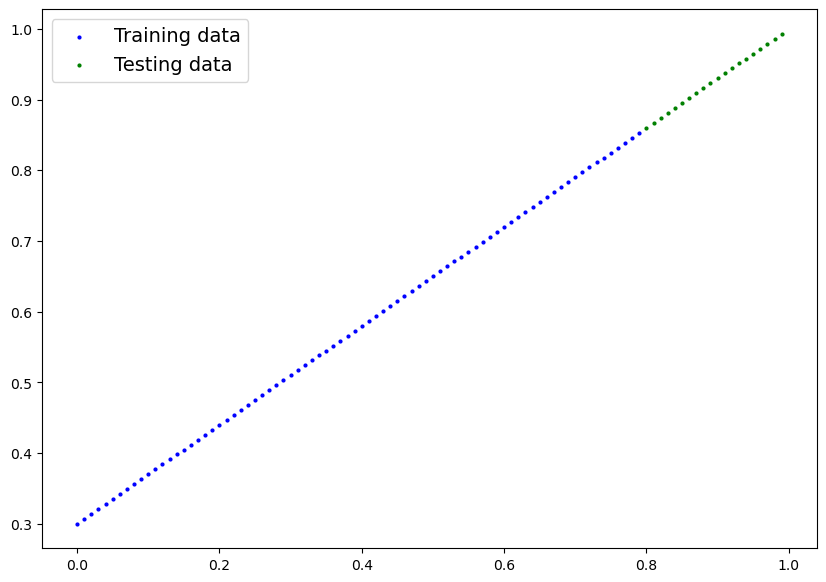

In [271]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
)

### 5.2 Adjusting model_1 to fit a straight line¶


In [272]:
model_2 = nn.Sequential(
                        nn.Linear(in_features=1, out_features=10),
                        nn.Linear(in_features=10, out_features=10),
                        nn.Linear(in_features=10, out_features=1)
).to(device)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [273]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params= model_2.parameters(), lr= 0.1)


In [274]:
epochs = 100

#Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):

    ### Training
    model_2.train()

    # Forward pass
    y_pred_regression = model_2(X_train_regression)

    # Loss function
    loss = loss_fn(y_pred_regression, y_train_regression)

    #Zero gradient
    optimizer.zero_grad()

    #Backpropagation
    loss.backward()

    #Optimizer steps
    optimizer.step()

    ### Testing
    model_2 .eval()
    with torch.inference_mode():
        #Forward pass
        test_pred = model_2(X_test_regression)
        #Caculate the loss
        test_loss = loss_fn(test_pred, y_test_regression)
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

Epoch: 0 | Train Loss: 0.75986 | Test Loss: 0.54143
Epoch: 10 | Train Loss: 0.14550 | Test Loss: 0.02363
Epoch: 20 | Train Loss: 0.14420 | Test Loss: 0.05597
Epoch: 30 | Train Loss: 0.10136 | Test Loss: 0.03785
Epoch: 40 | Train Loss: 0.07525 | Test Loss: 0.00984
Epoch: 50 | Train Loss: 0.07625 | Test Loss: 0.02102
Epoch: 60 | Train Loss: 0.10320 | Test Loss: 0.02754
Epoch: 70 | Train Loss: 0.08643 | Test Loss: 0.01007
Epoch: 80 | Train Loss: 0.06937 | Test Loss: 0.01326
Epoch: 90 | Train Loss: 0.08678 | Test Loss: 0.03027


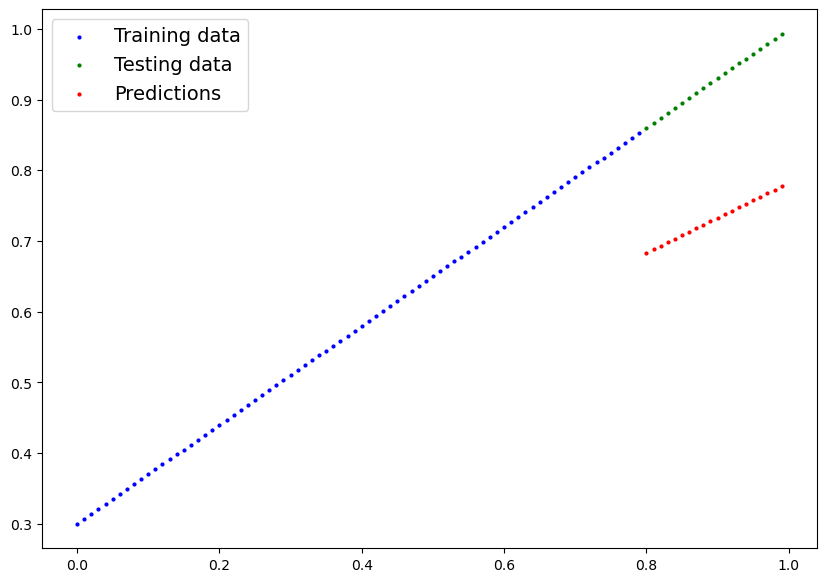

In [275]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())

A helpful troubleshooting step when building deep learning models is to start as small as possible to see if the model works before scaling it up.

This could mean starting with a simple neural network (not many layers, not many hidden neurons) and a small dataset (like the one we've made) and then overfitting (making the model perform too well) on that small example before increasing the amount data or the model size/design to reduce overfitting.

## 6. The missing piece: non-linearity

### 6.1 Recreating non-linear data (red and blue circles)

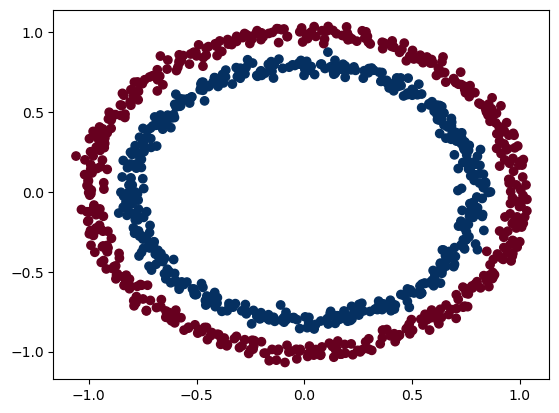

In [276]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [277]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

`One of the most common and best performing is ReLU (rectified linear-unit, torch.nn.ReLU()).`

In [278]:
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features= 2, out_features= 10)
        self.layer_2 = nn.Linear(in_features= 10, out_features= 10)
        self.layer_3 = nn.Linear(in_features= 10, out_features= 1)
        self.relu = nn.ReLU()
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [279]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

### 6.3 Training a model with non-linearity

In [280]:
torch.manual_seed(42)
epochs = 1000

#Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_3.train()

    # Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Caculate the loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true= y_train, y_pred= y_pred)

    #Zero-gradient
    optimizer.zero_grad()

    # Loss Backward
    loss.backward()

    # Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
        # Forward pass
        y_test_logits = model_3(X_test).squeeze()
        y_test_pred = torch.round(torch.sigmoid(y_test_logits))
        #Caculate the loss/accuracy
        test_loss = loss_fn(y_test_pred, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=y_test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} || Train Loss: {loss:.5f}, Train Accuracy: {acc:.2f} | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}")



Epoch: 0 || Train Loss: 0.69541, Train Accuracy: 50.00 | Test Loss: 0.69315, Test Accuracy: 50.00
Epoch: 100 || Train Loss: 0.69015, Train Accuracy: 53.12 | Test Loss: 0.75441, Test Accuracy: 50.00
Epoch: 200 || Train Loss: 0.68791, Train Accuracy: 54.25 | Test Loss: 0.75172, Test Accuracy: 54.50
Epoch: 300 || Train Loss: 0.68421, Train Accuracy: 58.88 | Test Loss: 0.72862, Test Accuracy: 59.00
Epoch: 400 || Train Loss: 0.67898, Train Accuracy: 62.25 | Test Loss: 0.69452, Test Accuracy: 64.50
Epoch: 500 || Train Loss: 0.67115, Train Accuracy: 64.00 | Test Loss: 0.67591, Test Accuracy: 67.50
Epoch: 600 || Train Loss: 0.65742, Train Accuracy: 72.00 | Test Loss: 0.66111, Test Accuracy: 69.50
Epoch: 700 || Train Loss: 0.63149, Train Accuracy: 85.12 | Test Loss: 0.58080, Test Accuracy: 84.00
Epoch: 800 || Train Loss: 0.58168, Train Accuracy: 91.88 | Test Loss: 0.54871, Test Accuracy: 91.50
Epoch: 900 || Train Loss: 0.49246, Train Accuracy: 93.88 | Test Loss: 0.54111, Test Accuracy: 93.50


### 6.4 Evaluating a model trained with non-linear activation functions

In [281]:
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

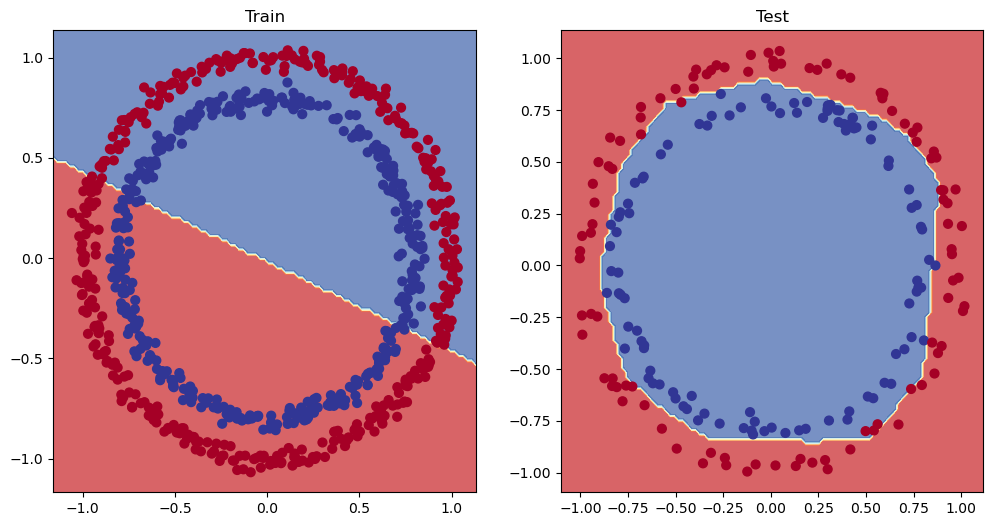

In [282]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

## 8. Putting things together by building a multi-class PyTorch model

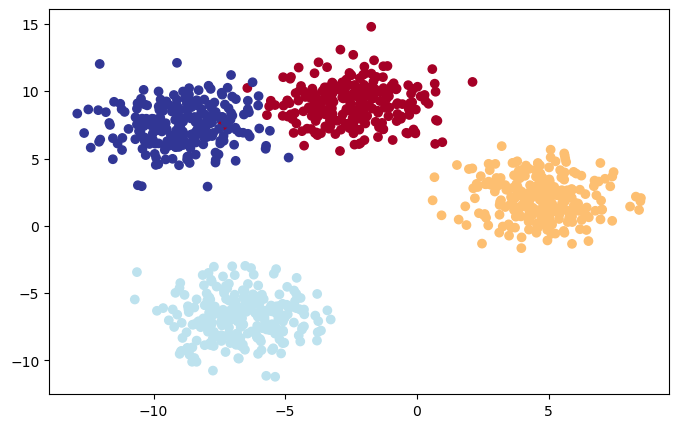

In [283]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000, n_features=2,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# Split into train and test set
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob, test_size=0.2,
                                                                        random_state=RANDOM_SEED)

#Plot data
plt.figure(figsize=(8,5))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)


In [284]:
len(X_blob_train), len(X_blob_test), len(y_blob_train), len(y_blob_test)

(800, 200, 800, 200)

### 8.2 Building a multi-class classification model in PyTorch

In [285]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [286]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units = 8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    def forward(self, x):
        return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [287]:
# Create loss and optimizer for multi-class
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)



### 8.4 Getting prediction probabilities for a multi-class PyTorch model

In [288]:
model_4(X_blob_train.to(device))[:5]

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], grad_fn=<SliceBackward0>)

In [289]:
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [290]:
# Make prediction logits with model
y_logits = model_4(X_blob_train.to(device))
print(len(y_logits))
# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

print(y_logits[:5])
print(y_pred_probs[:5])

800
tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], grad_fn=<SliceBackward0>)
tensor([[0.1838, 0.3422, 0.1500, 0.3239],
        [0.2199, 0.0377, 0.1839, 0.5586],
        [0.3406, 0.0482, 0.5326, 0.0785],
        [0.3405, 0.0657, 0.4446, 0.1492],
        [0.2527, 0.0424, 0.2283, 0.4766]], grad_fn=<SliceBackward0>)


In [291]:
# Sum the first sample output of the softmax activation function 
torch.sum(y_pred_probs[0])

tensor(1., grad_fn=<SumBackward0>)

In [292]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))
print(y_blob_train[0])
print(len(y_logits), len(X_blob_train))

tensor([0.1838, 0.3422, 0.1500, 0.3239], grad_fn=<SelectBackward0>)
tensor(1)
tensor(1)
800 800


### 8.5 Creating a training and testing loop for a multi-class PyTorch model¶


In [293]:
torch.manual_seed(42)

epochs = 10
#Put data to target device
X_blob_train,y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test,y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Train
    model_4.train()

    # Forward pass
    y_logits = model_4(X_blob_train)
    y_pred_probs = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # Caculate the loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred_probs)

    # Zero Gradient
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
        # Forward pass
        y_test_logits = model_4(X_blob_test)
        y_test_pred = torch.softmax(y_test_logits, dim=1).argmax(dim=1)
        #Caculate the loss, accuracy
        test_loss = loss_fn(y_test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=y_test_pred)

    # if epoch % 5 == 0:
    print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Train Accuracy: {acc:.2f} | Test loss: {test_loss:.5f}, Test accuracy: {test_acc:.2f}")

Epoch: 0 | Train loss: 1.04324, Train Accuracy: 65.50 | Test loss: 0.57861, Test accuracy: 95.50
Epoch: 1 | Train loss: 0.57519, Train Accuracy: 95.38 | Test loss: 0.42672, Test accuracy: 97.50
Epoch: 2 | Train loss: 0.42940, Train Accuracy: 96.88 | Test loss: 0.34695, Test accuracy: 99.00
Epoch: 3 | Train loss: 0.34478, Train Accuracy: 98.75 | Test loss: 0.28865, Test accuracy: 99.00
Epoch: 4 | Train loss: 0.28833, Train Accuracy: 98.62 | Test loss: 0.24888, Test accuracy: 99.50
Epoch: 5 | Train loss: 0.24757, Train Accuracy: 99.12 | Test loss: 0.21659, Test accuracy: 99.50
Epoch: 6 | Train loss: 0.21667, Train Accuracy: 98.88 | Test loss: 0.19233, Test accuracy: 99.50
Epoch: 7 | Train loss: 0.19247, Train Accuracy: 99.12 | Test loss: 0.17195, Test accuracy: 99.50
Epoch: 8 | Train loss: 0.17304, Train Accuracy: 99.12 | Test loss: 0.15571, Test accuracy: 99.00
Epoch: 9 | Train loss: 0.15716, Train Accuracy: 99.12 | Test loss: 0.14187, Test accuracy: 99.00


### 8.6 Making and evaluating predictions with a PyTorch multi-class model


In [294]:
model_4.eval()
with torch.inference_mode():
    y_logits_test = model_4(X_blob_test)
    y_pred_test = torch.softmax(y_logits_test, dim=1).argmax(dim=1)
y_pred_test[:10], y_blob_test[:10]


(tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0]),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0]))

Text(0.5, 1.0, 'Testing')

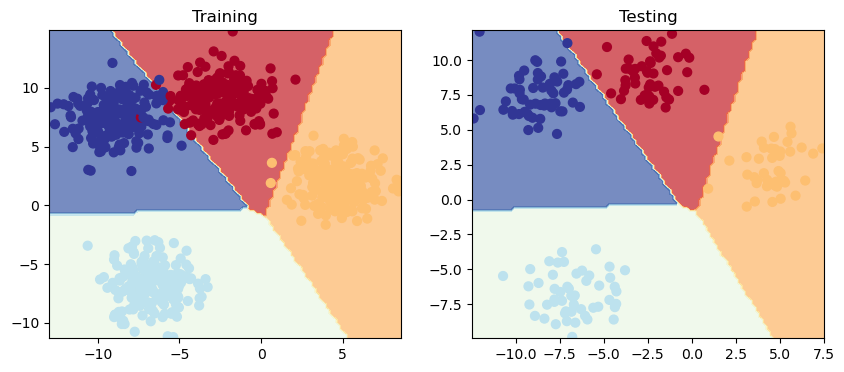

In [298]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.title("Training")

plt.subplot(1,2,2)
plot_decision_boundary(model_4, X_blob_test, y_blob_test)
plt.title("Testing")